# Testing New Model Performance

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import recall_score, precision_score, f1_score
import pickle
import os
import matplotlib as mpl

2023-05-10 17:10:22.607462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Helper functions for Graphing

In [2]:
def load_keras_model(model_name):
    model = tf.keras.models.load_model(model_name)

    return model

def display(display_list):
  plt.figure(figsize=(28, 28))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

# Get's the largest value between the two model filter layers then
# outputs a mask where each pixel denotes our models prediciton for each pixel
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def plot_loss_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.grid(True)

def plot_accuracy_learning_curves(loss, val_loss):
  plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training Accuracy")
  plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation Accuracy")
  plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
  # plt.axis([1, 20, 0, 0.05])
  plt.legend(fontsize=14)
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.grid(True)
  
def load_pkl_model_history(file_name):
  with open(file_name, "rb") as file_pi:
    history = pickle.load(file_pi)
  return history

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join("./", fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
      plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

### Data Preperation Functions from `util.py`

In [13]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

def preprocess(instance):
  # Resize each image from (720, 1280) -> (384, 640)
  resized = tf.image.resize(instance['image'], (384, 640))

  # Normalize the input to 0-1 range
  input_image = tf.cast(resized, tf.float32) / 255.0

  # Resize bitmask's from (720, 1280) -> (384, 640):
  resized_bitmask = tf.image.resize(instance['label'], (384, 640))

  # Replace pixel values equal to 255 with 0, else 1.
  # 255 pixel values arn't lane lines and other non 255
  # pixel's represent other lane line attributes. Our approach
  # is to simply identify a lane line or not, hence all lane 
  # lines are set to a value of 1.
  bitmask_label = tf.where(resized_bitmask == 255, 0, 1) 
  
  return (input_image, bitmask_label)

# Loads a subset of the bdd100k dataset and returns it.
# The dataset contains "train", "validate", and "test" sections
def load_10k_data():
  # Parial implementation for new model testing purposes
#   train, valid = tfds.load('bdd', split=['train[:2000]', 'test[:2000]'])
#   train_set = train.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(700).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
#   validate_set = valid.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(700).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Full implementation:
  dataset = tfds.load('bdd')

  # train_set = dataset['train'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
  # # This should have called validation portion of dataset but is left now
  # # Since our model is trainined with this implemenation
  # validate_set = dataset['test'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(1000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

  # Only data that's require for further testing
  test_set = dataset['validate'].map(preprocess, num_parallel_calls=tf.data.AUTOTUNE).batch(1)
  
  return train_set, validate_set, test_set

In [14]:
# Load Datastets
train_set, validate_set, test_set = load_10k_data()

# Milestone 4 Best Model with Recent Bitmask Label Swaps

19th epoch training and validation loss:
- loss: 0.0268 - accuracy: 0.9907 - val_loss: 0.0325 - val_accuracy: 0.9906

In [15]:
trained_model = load_keras_model("model_d10_full_45epoch_swapped")

### Display Predictions on Sample Data

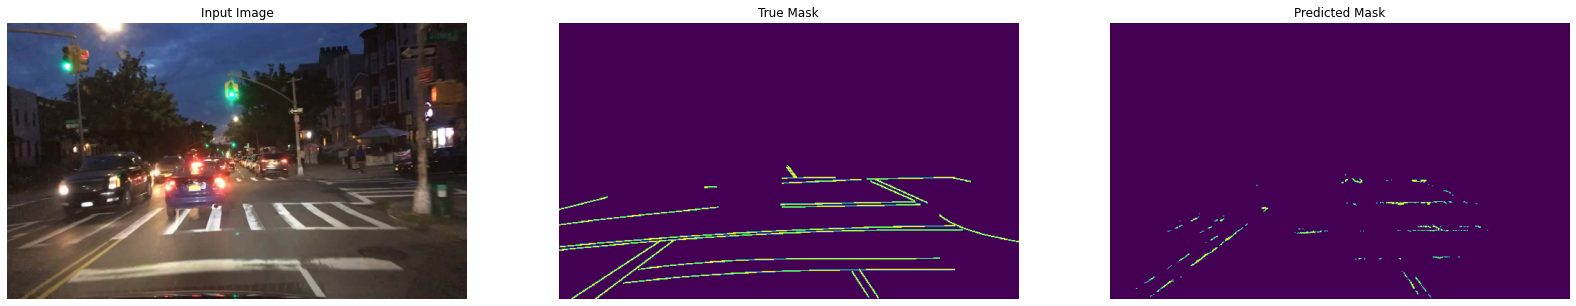

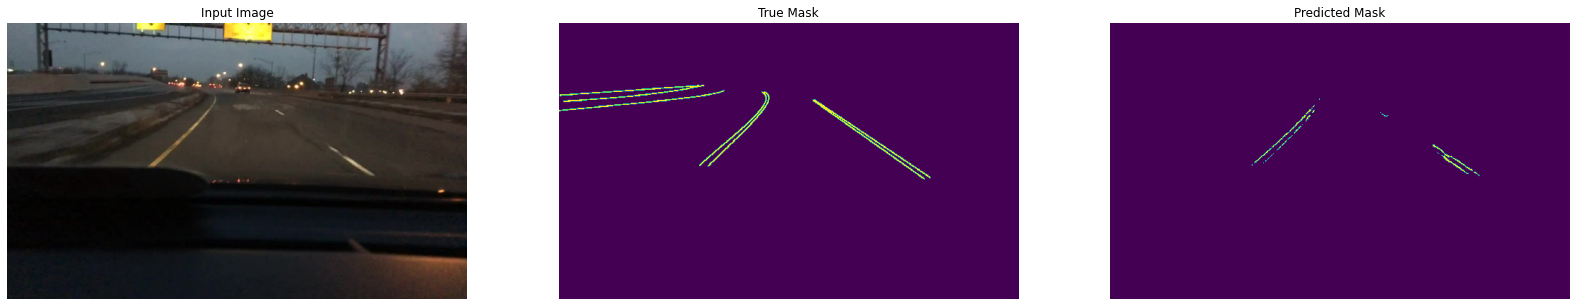

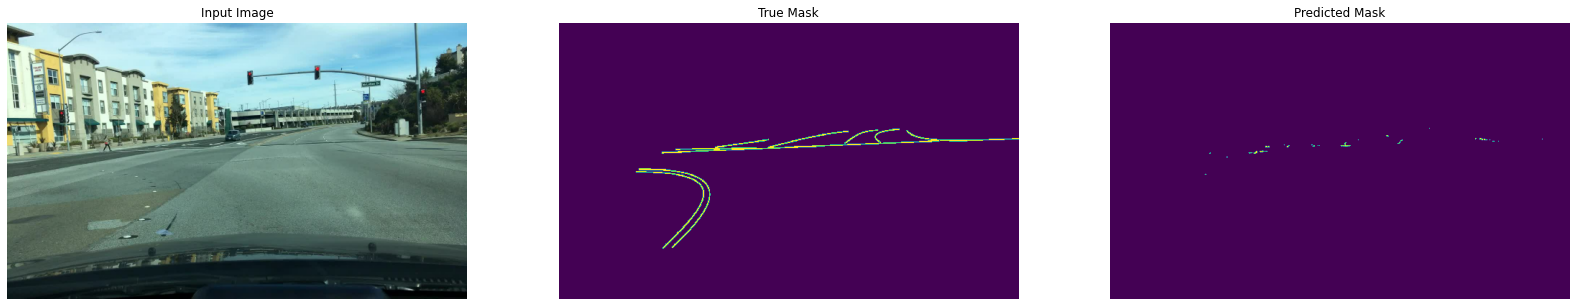

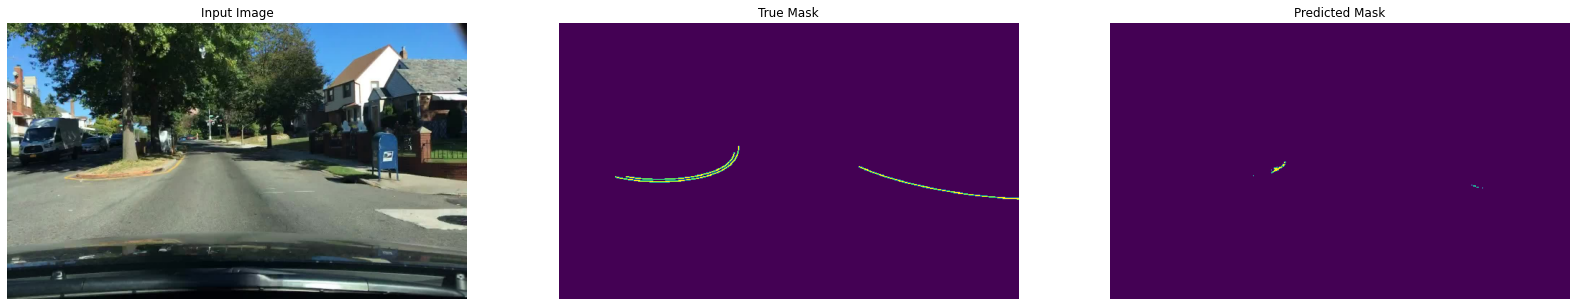

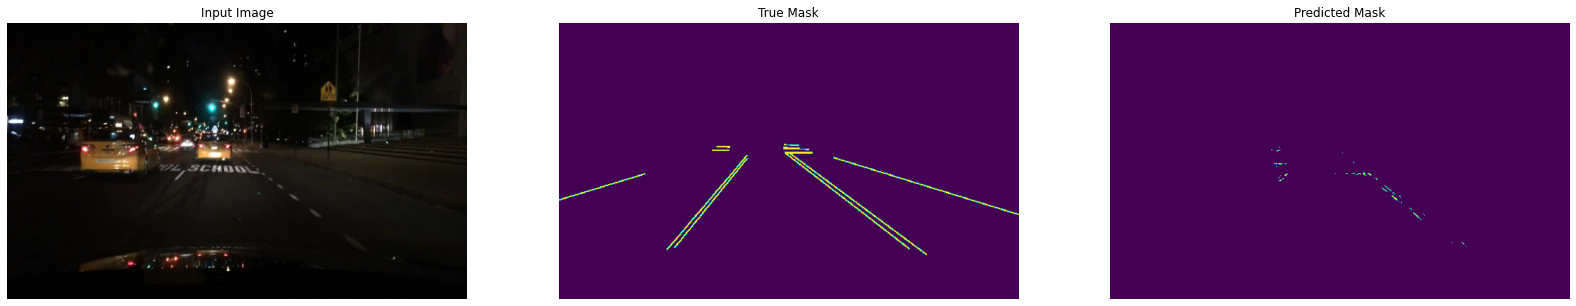

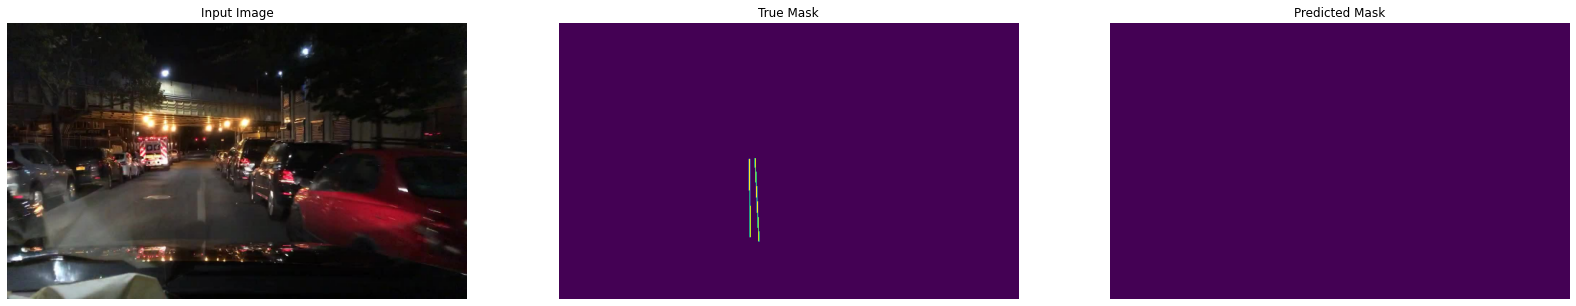

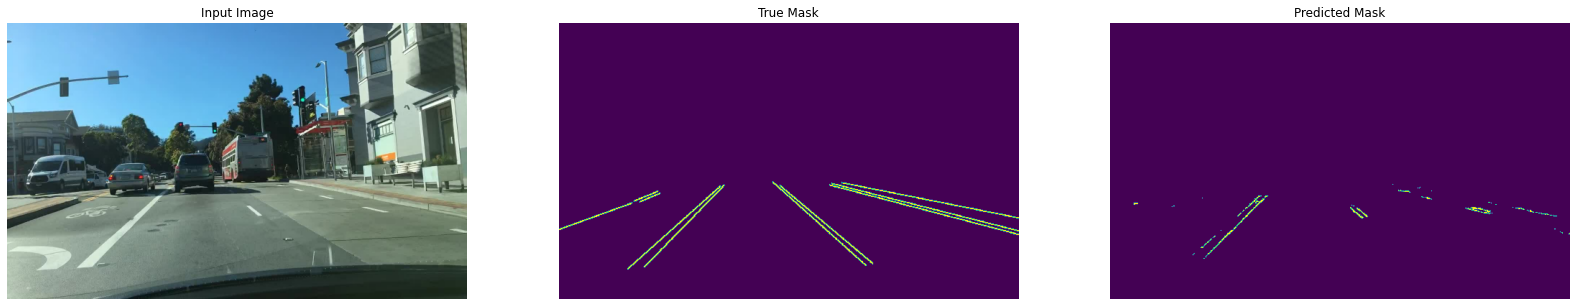

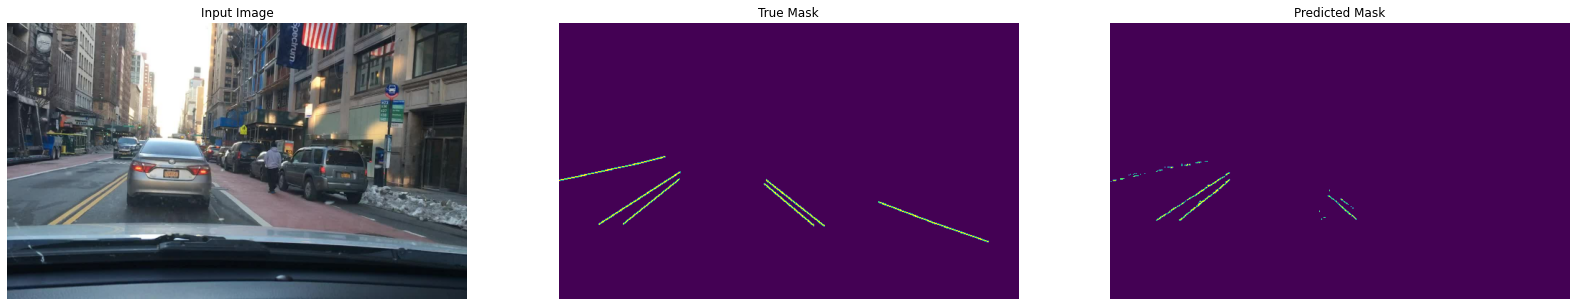

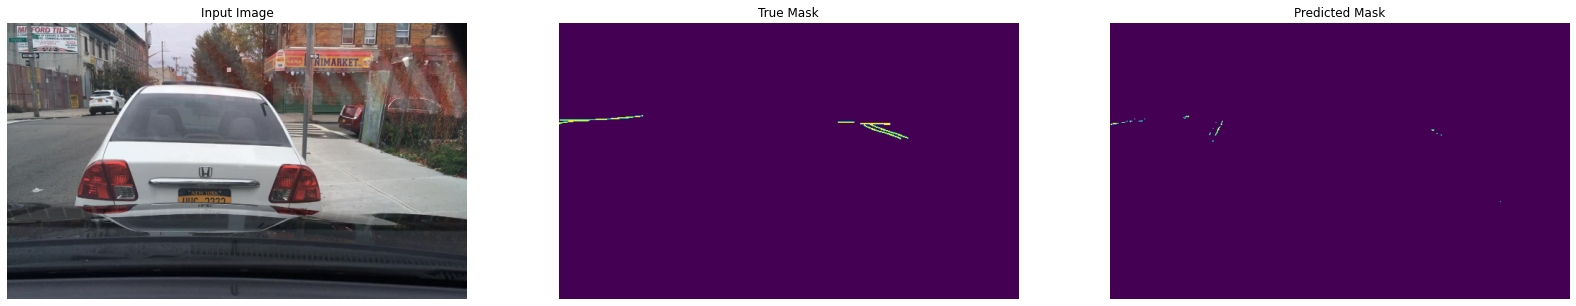

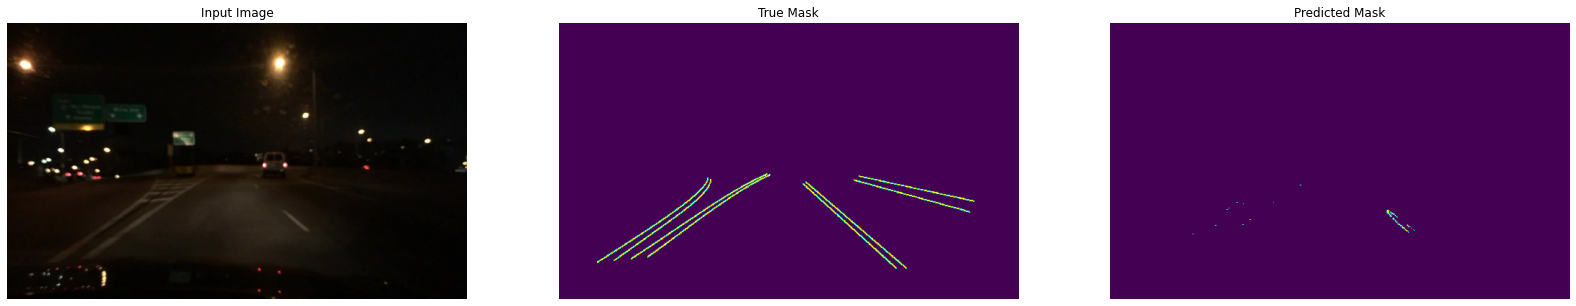

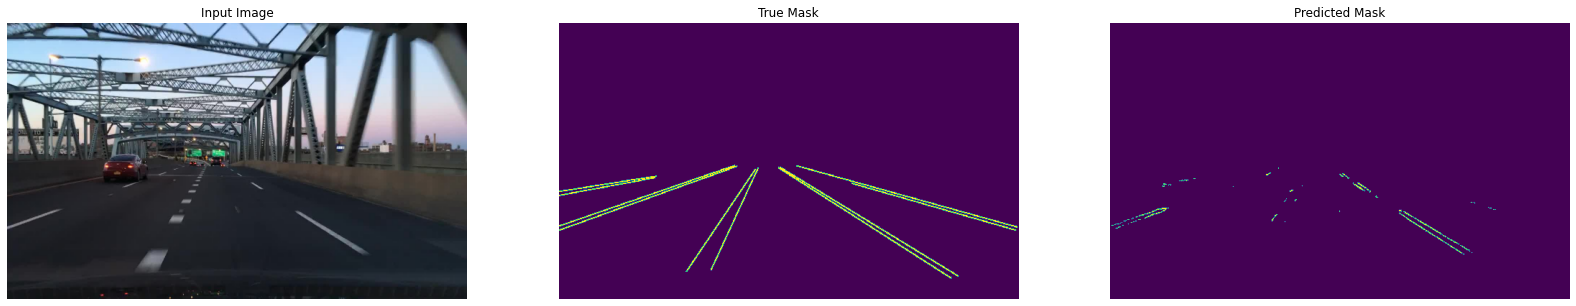

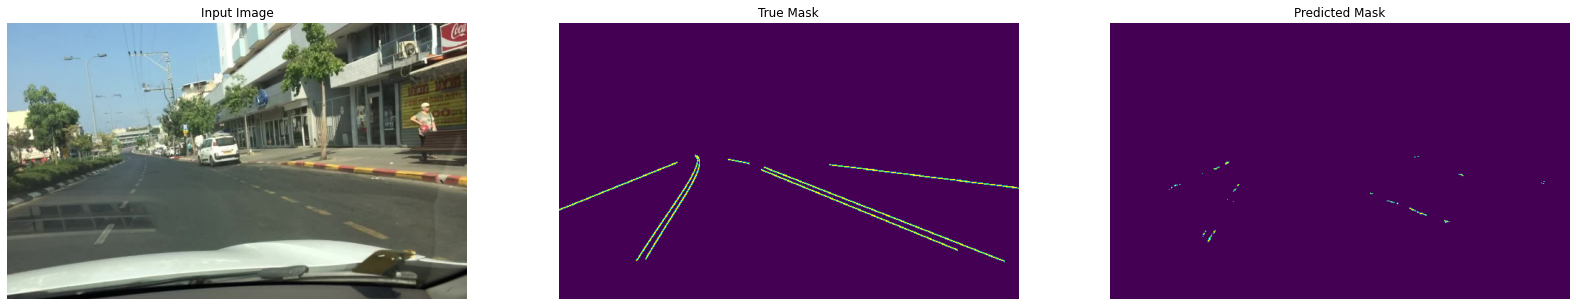

In [26]:
index = 0
for data in test_set:
  if index < 30:
    index += 1
    continue 

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  display([unbatched_img, unbatched_mask, create_mask(trained_model.predict(dat_img, verbose=0))])

  if (index > 40):
    break

  index += 1

### Displaying Training History

In [17]:
# Load history
history = load_pkl_model_history("model_d10_full_45epoch_swapped_history.pkl")

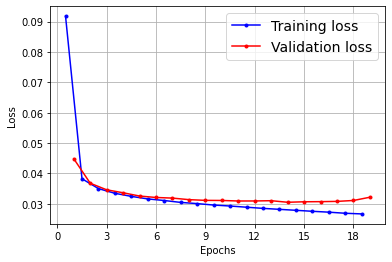

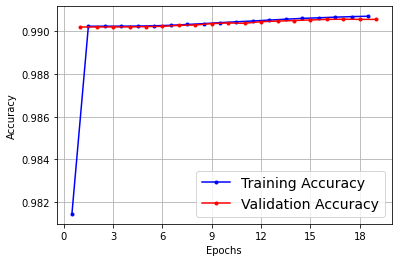

In [18]:
# Plot loss curves vs epoch
plot_loss_learning_curves(history["loss"], history["val_loss"])
# save_fig("model_d10_train_vs_val_loss")
plt.show()

# Plot accuracy curves vs epoch
plot_accuracy_learning_curves(history["accuracy"], history["val_accuracy"])
# save_fig("model_d10_train_vs_val_acc")
plt.show()

## New Metric Testing

### Gather Predictions and Labels For Evaluation 

In [21]:
predictions = []
labels = []
# CAUTION the Test set contains 1000 images, this takes roughly 5 minutes to run 
# on i5 processor
for data in test_set:

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  # Flatten 2D to 1D to allow for interpretion of sklearn metrics
  # such as recall, precision, and f1 score
  flattened_mask = np.array(unbatched_mask).flatten()
  pred_mask = create_mask(trained_model.predict(dat_img, verbose=0))
  flattened_pred_mask = np.array(pred_mask).flatten()

  predictions.append(flattened_pred_mask)
  labels.append(flattened_mask)

### Analyze on Precision, Recall, and F1 Score

In [22]:
# For all the correct boundaries, what percentage were found
recall = recall_score(labels, predictions, zero_division=0, average='samples')
print("recall = ", recall)

# For Lane lines that were predicted, how many were correct
precision = precision_score(labels, predictions, zero_division=0, average='samples')
print("precision score = ", precision)

# Harmonic mean of precision and recall
f_one = f1_score(labels, predictions, zero_division=0, average='samples')
print("f1 score = ", f_one)

recall =  0.07906874585714659
precision score =  0.48898496710651296
f1 score =  0.1261169077894241


# Model with 3 New layers Trained on Full dataset With 45 epochs and early stopping of 10 epochs

Last epoch (27th) training and validation loss:
- loss: 0.0218 - accuracy: 0.9914 - val_loss: 0.0304 - val_accuracy: 0.9906

In [23]:
new_model = load_keras_model("model_d11_3new_full_45e_10pat")

/usr/local/lib/python3.9/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


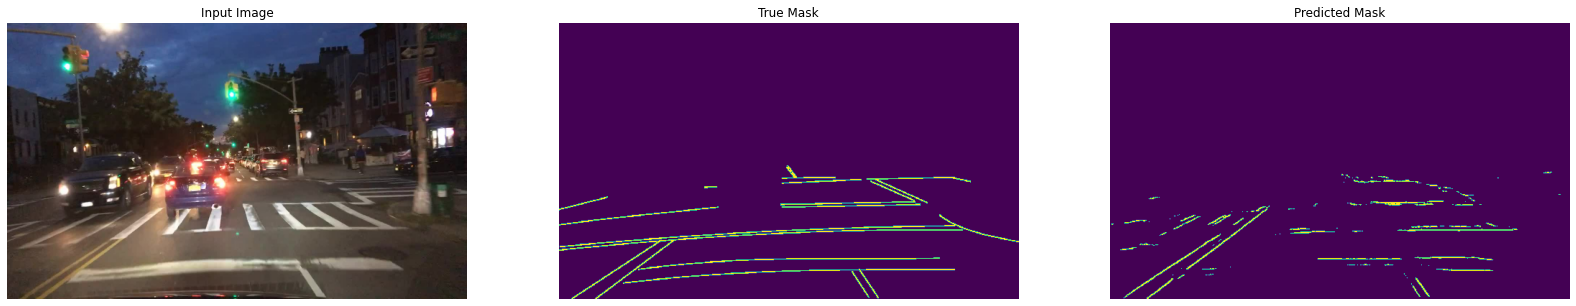

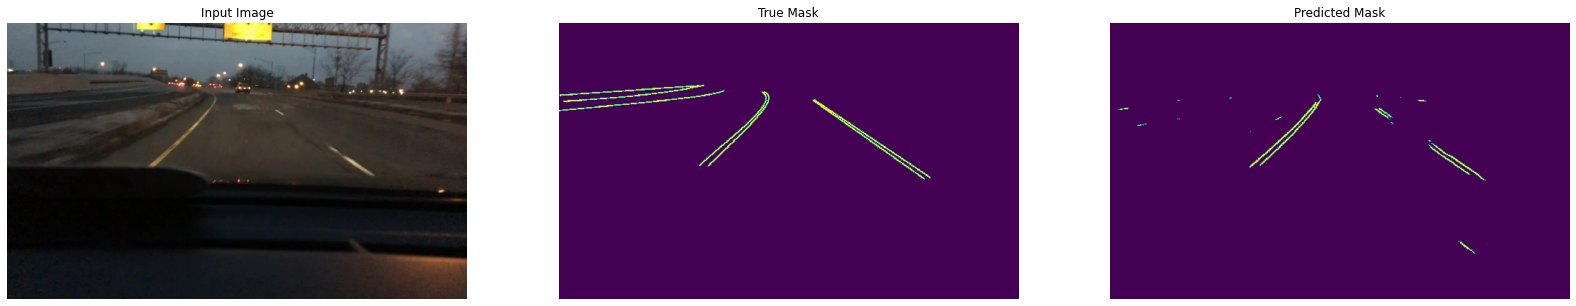

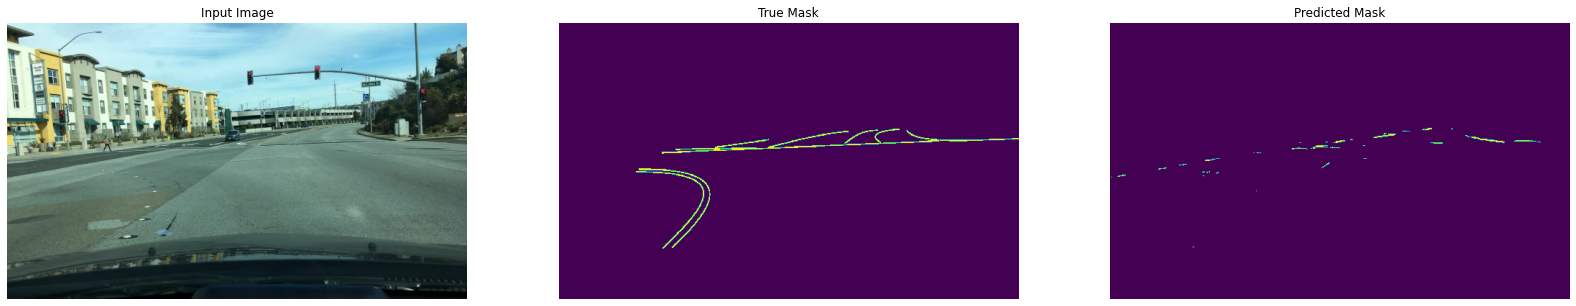

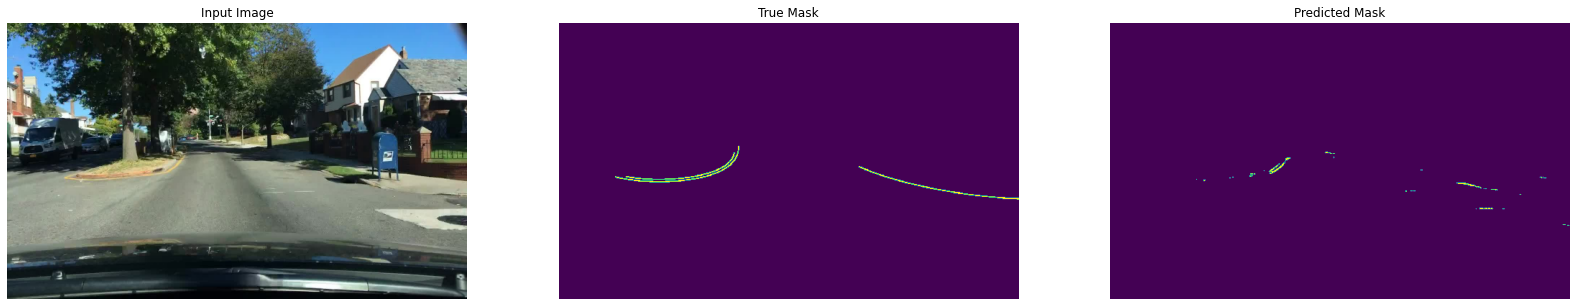

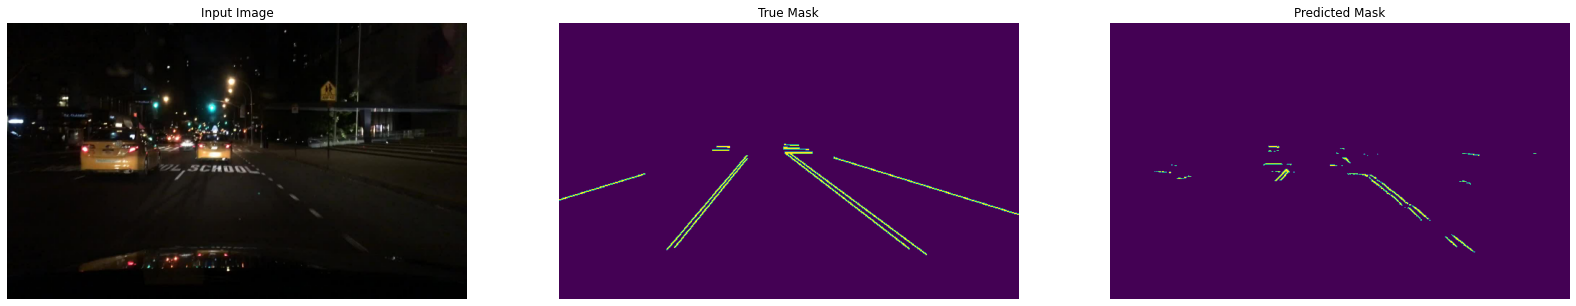

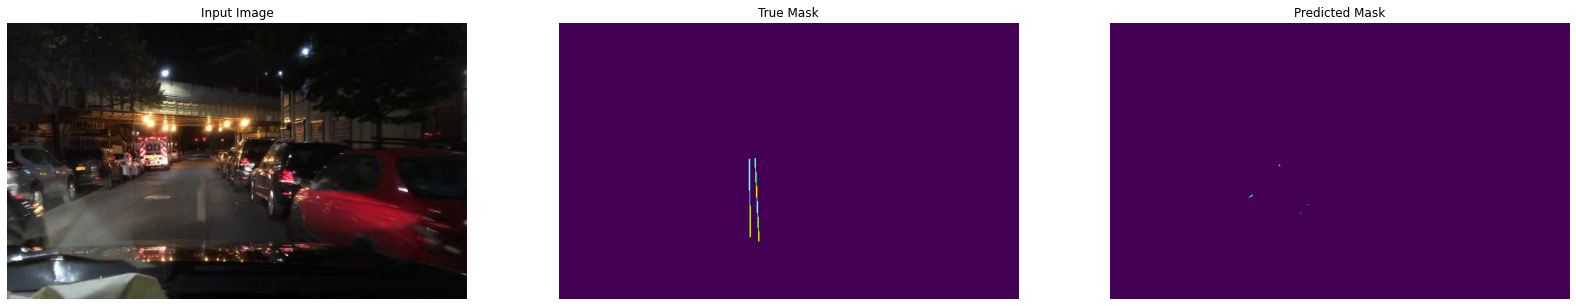

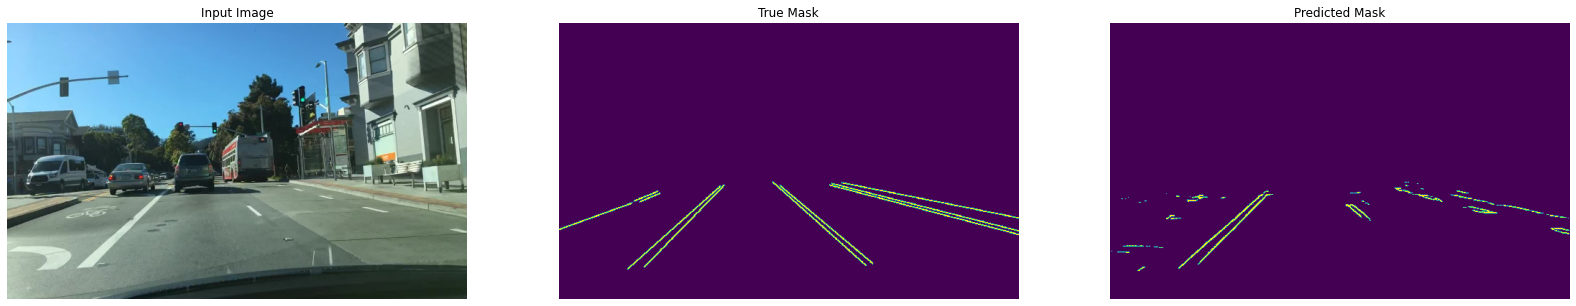

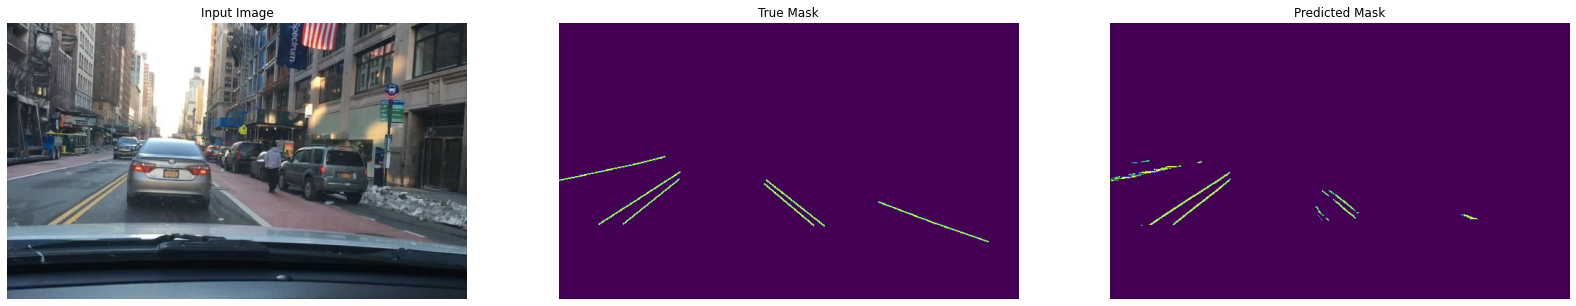

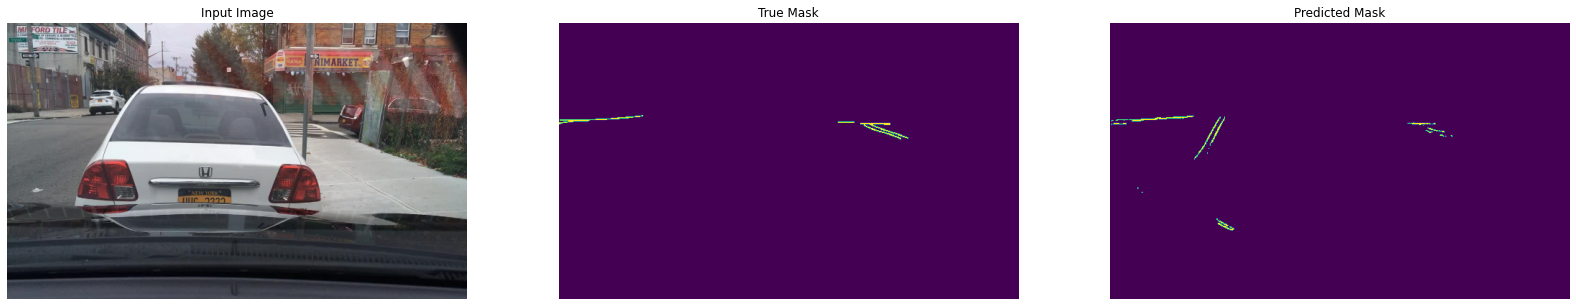

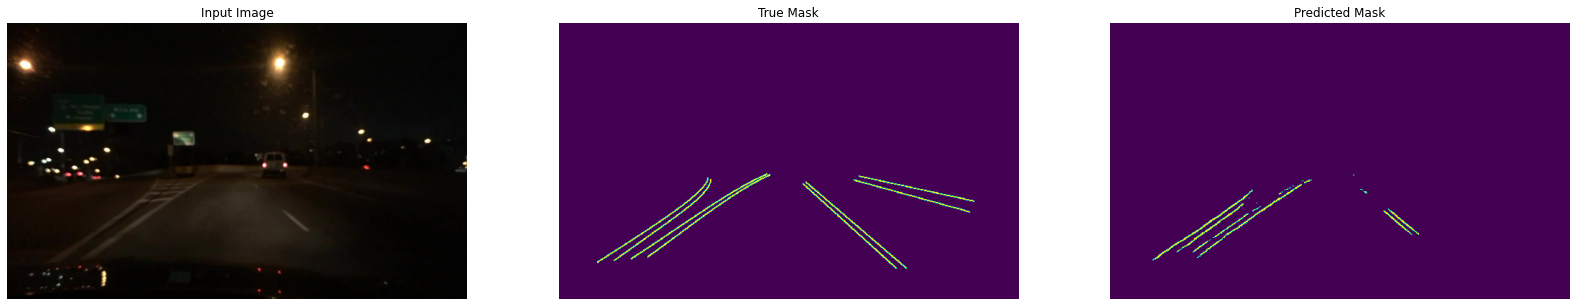

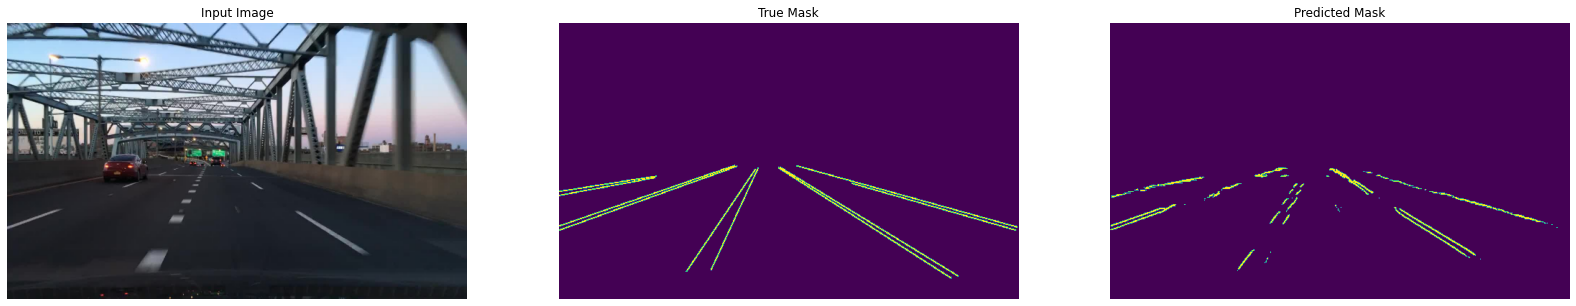

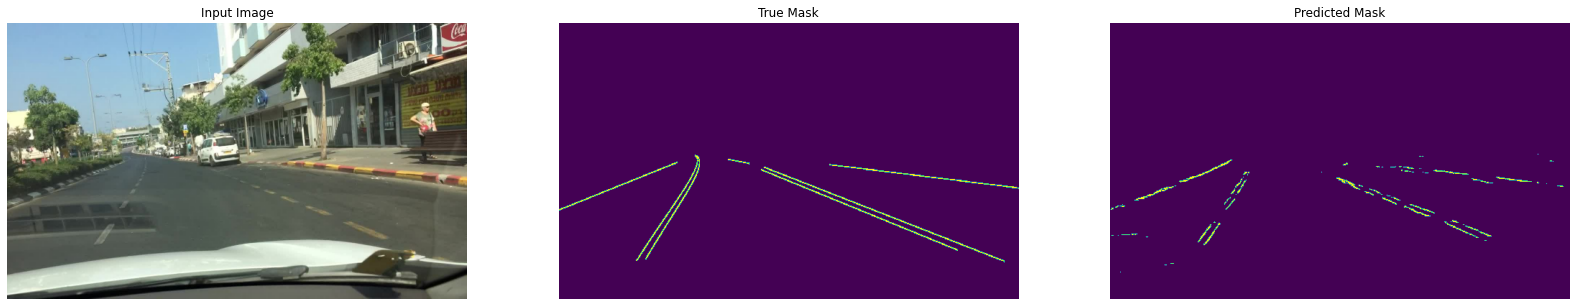

In [25]:
index = 0
for data in test_set:
  if index < 30:
    index += 1
    continue 

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  display([unbatched_img, unbatched_mask, create_mask(new_model.predict(dat_img, verbose=0))])

  if (index > 40):
    break

  index += 1

Saving figure Figures/model_d11_3new_full_45_10pat_loss_plot


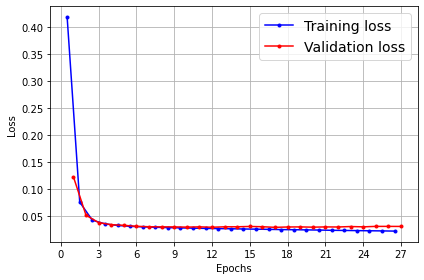

Saving figure Figures/model_d11_3new_full_45_10pat_acc_plot


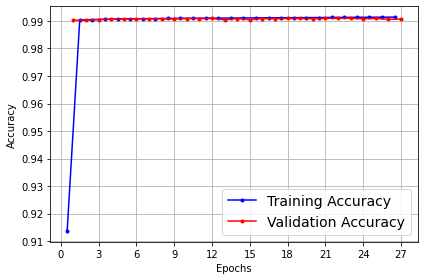

In [28]:
# Load history
new_history = load_pkl_model_history("model_d11_3new_full_45_10pat_history.pkl")

# Plot loss curves vs epoch
plot_loss_learning_curves(new_history["loss"], new_history["val_loss"])
save_fig("Figures/model_d11_3new_full_45_10pat_loss_plot")
plt.show()

# Plot accuracy curves vs epoch
plot_accuracy_learning_curves(new_history["accuracy"], new_history["val_accuracy"])
save_fig("Figures/model_d11_3new_full_45_10pat_acc_plot")
plt.show()

In [29]:
predictions = []
labels = []
# CAUTION the Test set contains 1000 images, this takes roughly 5 minutes to run 
# on i5 processor
for data in test_set:

  dat_img = data[0] # dat_img.shape => (1, 368, 640, 3)
  original_mask = data[1] #  original_mask.shape => (1, 368, 640, 1)

  unbatched_img = dat_img[0] # shape => (368, 640, 3)
  unbatched_mask = original_mask[0] # shape => (368, 640, 1)

  # Flatten 2D to 1D to allow for interpretion of sklearn metrics
  # such as recall, precision, and f1 score
  flattened_mask = np.array(unbatched_mask).flatten()
  pred_mask = create_mask(new_model.predict(dat_img, verbose=0))
  flattened_pred_mask = np.array(pred_mask).flatten()

  predictions.append(flattened_pred_mask)
  labels.append(flattened_mask)

In [30]:
# For all the correct boundaries, what percentage were found
recall = recall_score(labels, predictions, zero_division=0, average='samples')
print("recall = ", recall)

# For Lane lines that were predicted, how many were correct
precision = precision_score(labels, predictions, zero_division=0, average='samples')
print("precision score = ", precision)

# Harmonic mean of precision and recall
f_one = f1_score(labels, predictions, zero_division=0, average='samples')
print("f1 score = ", f_one)

recall =  0.24045479137700607
precision score =  0.45675194030061605
f1 score =  0.29900536636984


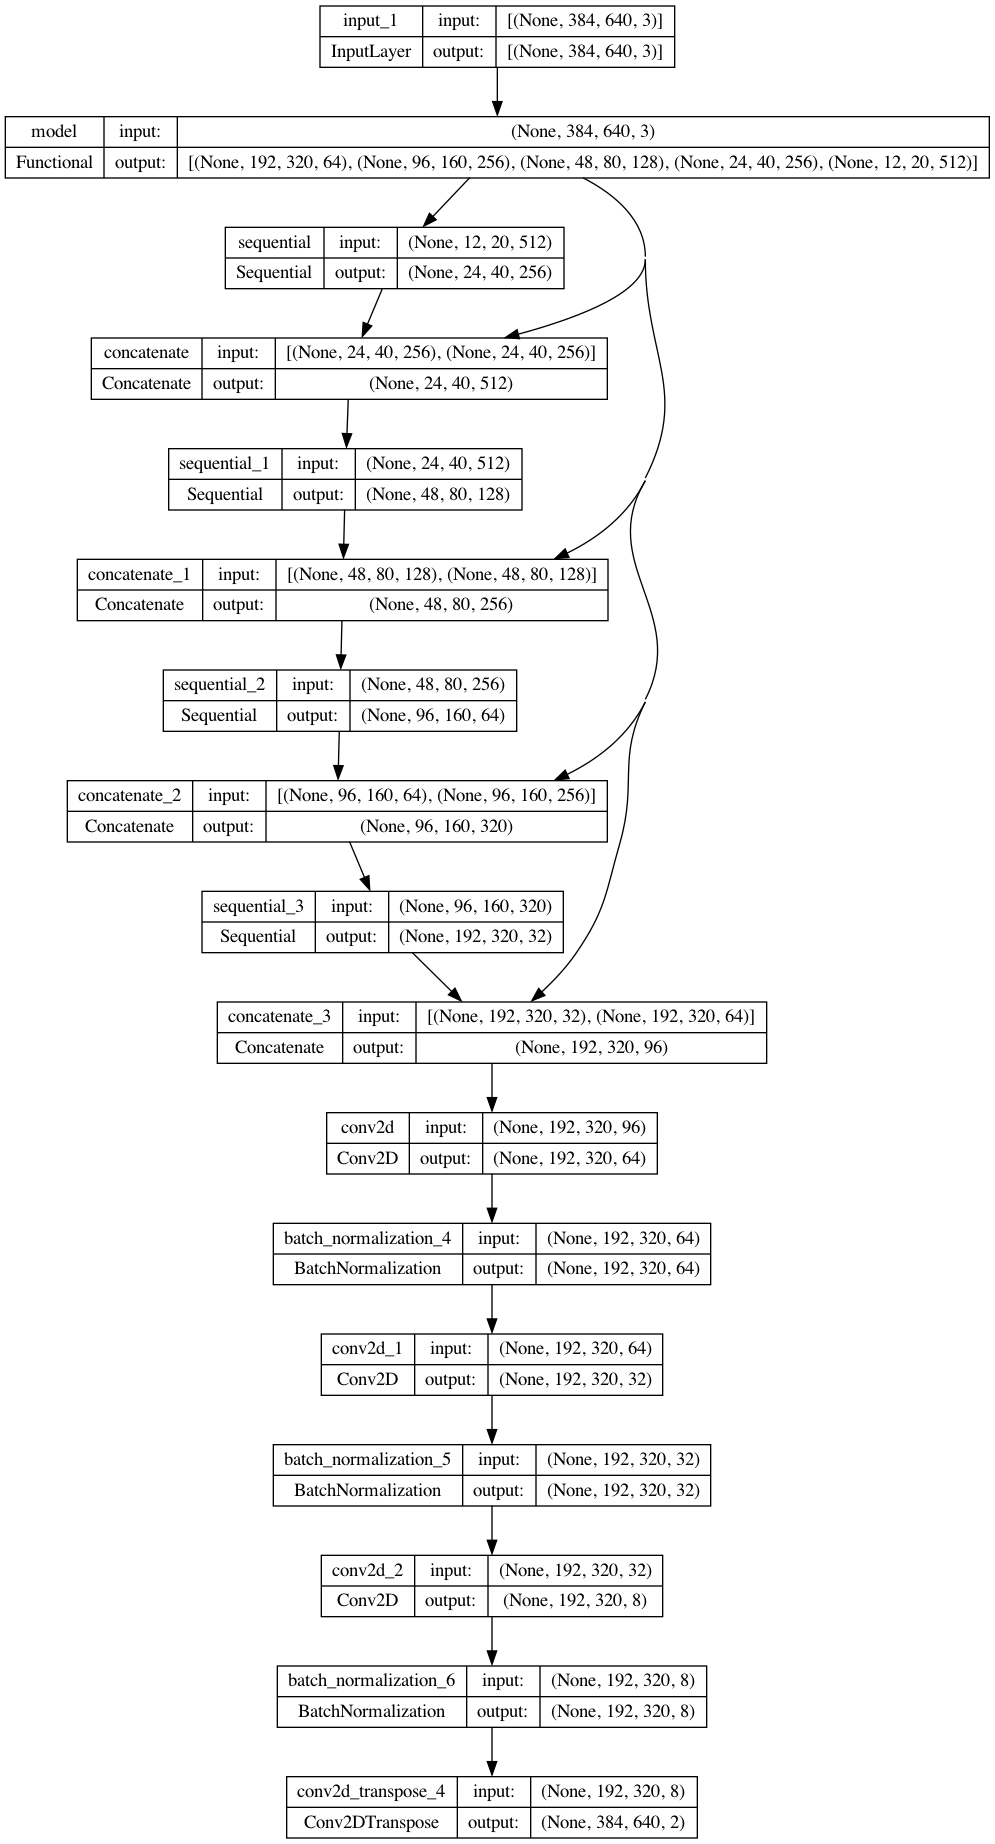

In [31]:
tf.keras.utils.plot_model(new_model, show_shapes=True)